# ACCURACY OF LINEAR MODELS

This notebook introduces core elements of the CalTech control package and provides various examples of using the with Tellurium.

# Preliminaries

In [1]:
!pip install -q control
!pip install -q tellurium

import control
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

     |████████████████████████████████| 357 kB 22.7 MB/s 
     |████████████████████████████████| 121 kB 29.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 54.8 MB 1.2 MB/s 
     |████████████████████████████████| 6.9 MB 43.8 MB/s 
     |████████████████████████████████| 2.1 MB 41.5 MB/s 
     |████████████████████████████████| 36.7 MB 1.2 MB/s 
     |████████████████████████████████| 5.6 MB 29.1 MB/s 
     |████████████████████████████████| 5.8 MB 46.3 MB/s 
     |████████████████████████████████| 2.6 MB 52.9 MB/s 
     |████████████████████████████████| 3.2 MB 50.5 MB/s 
     |████████████████████████████████| 3.3 MB 60.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Antimony Models

### Linear Model

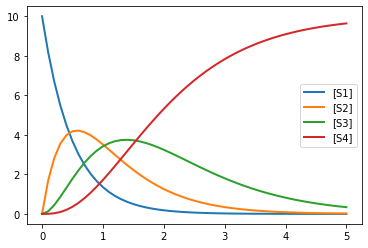

In [2]:
LINEAR_MDL = """
JL1: S1 -> S2; k1*S1
JL2: S2 -> S3; k2*S2
JL3: S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_DATA = LINEAR_RR.simulate()
LINEAR_RR.plot(LINEAR_DATA)

### Nonlinear Model

This is a non-linear model because of the presence of a reaction with two reactions, ``JN2``,
with mass action kinetics.

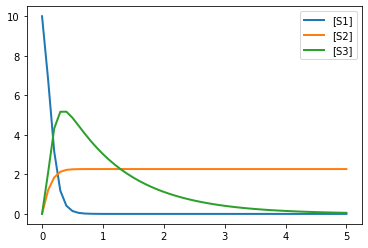

In [3]:
NONLINEAR_MDL = """
JN1: S1 -> S2; k1*S1
JN2: S1 +  S2 -> 3 S3; k2*S1*S2
JN3: S3 -> ; k3*S3
JN4: 2 S1 + S3 -> S2; k4*S1*S3

k1 = 2
k2 = 1.5
k3 = 1
k4 = 0.5
S1 = 10
S2 = 0
S3 = 0
"""
NONLINEAR_RR = te.loada(NONLINEAR_MDL)
NONLINEAR_DATA = NONLINEAR_RR.simulate()
NONLINEAR_RR.plot(NONLINEAR_DATA)

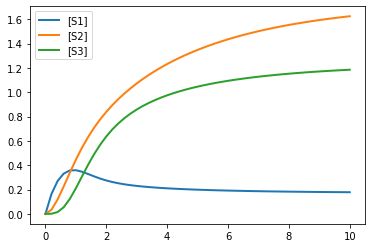

In [4]:
NONLINEAR_STEP_MDL = """
JN0: -> S1; 1
JN1: S1 -> S2; k1*S1
JN2: S1 +  S2 -> 3 S3; k2*S1*S2
JN3: S3 -> ; k3*S3
JN4: 2 S1 + S3 -> S2; k4*S1*S3

k1 = 2
k2 = 1.5
k3 = 1
k4 = 0.5
S1 = 0
S2 = 0
S3 = 0
"""
rr = te.loada(NONLINEAR_STEP_MDL)
rr.simulate(0, 10)
rr.plot()

## Constants

# Helpers

In [5]:
def getStateDct(time, roadrunner=NONLINEAR_RR):
    """
    Retrieves the value of state at the specified time.
    Changes the time of the roadrunner.
    
    Parameters
    ----------
    time: float
    roadrunner: ExtendedRoadrunner
    
    Returns
    -------
    dict
        key: species name
        value: species value
    """
    roadrunner.reset()
    if time > 0:
        roadrunner.simulate(0, time)
    species_lst = roadrunner.getFloatingSpeciesIds()
    dct = {s: roadrunner[s] for s in species_lst}
    return dct
        
# Tests
dct = getStateDct(0.5)
assert(len(dct) == 3)
dct1 = getStateDct(1)  # Get different values at a different time
assert(all([dct[s] != dct1[s] for s in dct.keys()]))
print("OK!")

OK!


In [6]:
def getStateValues(time, **kwargs):
    """
    Gets the values of state at the specified time.
    
    Parameters
    ----------
    time: float
    kwargs: dict
        keyword arguments for getStateDct
        
    Returns
    -------
    np.array
    """
    return np.array(list(getStateDct(time, **kwargs).values()))
        
# Tests
arr = getStateValues(0)
assert(isinstance(arr, np.ndarray))
assert(len(arr) == 3)
print("OK!")

OK!


In [7]:
def plotRR(roadrunner=NONLINEAR_RR, is_plot=True):
    """
    Plots species from running a simulation.
    """
    roadrunner.reset()
    roadrunner.simulate(0, 5, 100)
    if is_plot:
        roadrunner.plot()

# Tests
plotRR(is_plot=False)
print("OK!")

OK!


# Constructing a Linear Approximation

Here, we show how to construct a linear approximation for a nonlinear reaction network.
The running example is ``NONLINEAR_MDL``.

The state vector is ${\bf x} = [S_1, S_2, S_3]^T$.

1. Choose an operating point, $\bar{\bf x}$.
1. Calculate the Jacobian, ${\bf A}$, of the system equations at the operating point.
1. Solve the linear system $\dot{\tilde {\bf x}}  = {\bf A} {\tilde {\bf x}}$ to obtain $\tilde {\bf x} (t)$.
1. Calculate the approximation for ${\bf x}(t) \approx \bar{\bf x} + \tilde{\bf x}(t)$.

## 1: Choose an operating point

In the sequel, we'll use $\bar{x} = [ \bar{S}_1, \bar{S}_2, \bar{S}_3 ]^T = [1.18,~ 2.13,~ 5.17]^T$.
We use $N$ to denote the number of states.

$\tilde {\bf x} = {\bf x} - \bar{ \bf x}$

In [8]:
OP_TIME = 0.3
OP_VEC = getStateValues(OP_TIME)
NUM_STATE = len(OP_VEC)
X0 = getStateValues(0)  # Initial values for simulation from time 0
print(OP_VEC)

[1.1771823  2.13018048 5.16669862]


## 2: Calculate the Jacobian at the operating point

In [9]:
# Get the Jacobian at the time of the operating point
#  Simulate to the operating point
NONLINEAR_RR.reset()
NONLINEAR_RR.simulate(0, OP_TIME)
#  Extract the Jacobian
A = NONLINEAR_RR.getFullJacobian()
A

           S1,       S2,       S3
S1 [[ -10.362, -1.76577, -1.17718],
S2  [ 1.38808, -1.76577, 0.588591],
S3  [ 7.00246,  5.29732, -1.58859]]

## 3: Solve the linear system for $\tilde{x}$

We'll use the ``control`` package to construct a transfer function.
This means that we need to specify the input and output.
For this example, the input is $S_1$ and the output is $S_3$.
So, $G(s) = \frac{S_3(s)}{S_1(s)}$.

The first substep is to create a ``StateSpace`` object
that has $S_1$ as its input and $S_3$ as its output.

\begin{eqnarray}
\dot {\tilde {\bf x}} &=& A \tilde{ {\bf x}} + {\bf B} u \\
y & = & {\bf C} \tilde{ {\bf x}} + {\bf D}  u \\
\end{eqnarray}

Note that $y$, ${\bf x}$, and $u$ are a function of time.
Beause this is a Single Input Single Output (SISO) system, the input $u$ and the output $y$ are scalars for any time $t$.

In [10]:
# Obtain the Jacobian at the operating point
NONLINEAR_RR.reset()
NONLINEAR_RR.simulate(0, OP_TIME)
A = NONLINEAR_RR.getFullJacobian()
A

           S1,       S2,       S3
S1 [[ -10.362, -1.76577, -1.17718],
S2  [ 1.38808, -1.76577, 0.588591],
S3  [ 7.00246,  5.29732, -1.58859]]

### Construct the state space matrices

Now, we have to construct ${\bf B}$, ${\bf C}$, ${\bf D}$.

${\bf B}$ has dimension $N \times 1$ since there is one input.
This input is $S_1$.
So, $u$ should only affect $S_1$.
That is,
${\bf B} =
\begin{bmatrix}
1 \\
0 \\
0\\
\end{bmatrix}.
$

In [11]:
B = np.array([1, 0, 0])
B = np.reshape(B, (NUM_STATE, 1))
np.shape(B)

(3, 1)

In [12]:
# Consider that our input is S2 instead of S1
B2 = np.array([0, 1, 0])

${\bf C}$ has dimension $1 \times N$ since there is only one output.
This output is $S_1$.
So, we want to select only $S_3$ output of the state vector.
That is,
${\bf C} =
\begin{bmatrix}
0 \\
0 \\
1\\
\end{bmatrix}.
$

In [13]:
C = np.array([0, 0, 1])
C = np.reshape(C, (1, NUM_STATE))
np.shape(C)

(1, 3)

${\bf D}$ is not used in this model, and so it should be all zeroes.
It must have the same number of rows as there are outputs, and the same number of columns as there are inputs.
So, ${\bf D} = 0$.

In [14]:
D = 0

### Construct the ``control`` objects

In [15]:
NONLINEAR_SS_1_3 = control.StateSpace(A, B, C, D)
print(NONLINEAR_SS_1_3)

A = [[-10.36196935  -1.76577345  -1.1771823 ]
     [  1.38807859  -1.76577345   0.58859115]
     [  7.00246286   5.29732035  -1.58859115]]

B = [[1.]
     [0.]
     [0.]]

C = [[0. 0. 1.]]

D = [[0.]]



### Run a simulation With the Transfer Function Object

We will do the simulation using ``control.

In [16]:
times = [0.1*v for v in range(51)]
result = control.forced_response(NONLINEAR_SS_1_3, times, X0=getStateValues(0))

Text(0.5, 1.0, 'S3 with initial conditions')

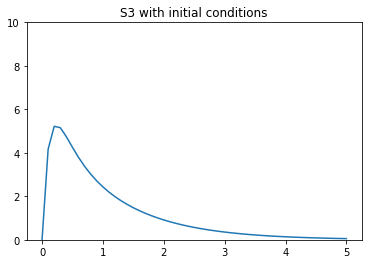

In [17]:
# result.t are the times of the simulation
# result.y are the output values
plt.plot(result.t.flatten(), result.y.flatten())
plt.ylim([0, 10])
plt.title("S3 with initial conditions")

(0.0, 10.0)

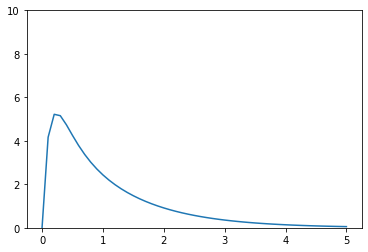

In [18]:
result1 = control.impulse_response(NONLINEAR_SS_1_3, T=times)
plt.plot(result1.t.flatten(), 10*result1.y.flatten())
plt.ylim([0, 10])

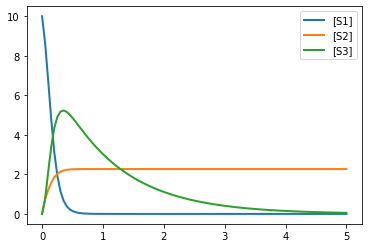

In [19]:
plotRR()

## 4: Calculate the approximation

This is unnecessary because ``control.forced_input`` takes initial conditions into account, which is the $\bar{\bf x}$. 

# Homework Dicussion

In [20]:
def analyze(time, species):
    """
    Plots comparisons of the Tellurium simulation of the original model with
    its linearization at a time point for a particular species.
    The analysis is for NONLINEAR_MDL.

    Parameters
    ----------
    time: float
    species: str
        e.g. "S2", "S3"
    """

In [21]:
for time in [0, 0.3, 2.0]:
    for species in ["S2", "S3"]:
        analyze(time, species)